In [983]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [984]:
df = pd.read_csv('data.csv')

df.head()

,brand,price,year,mileage,damage_type,number_of_owners,number_of_services
0,Dodge,14499,2015,115373,unknown,2,9
1,Kia,9995,2017,84579,none,1,3
2,Chevrolet,11995,2017,77315,none,3,13
3,Nissan,9995,2015,94783,none,1,15
4,Volkswagen,11977,2021,137978,none,1,13


In [985]:
df.sample(5)

,brand,price,year,mileage,damage_type,number_of_owners,number_of_services
18,Mazda,10500,2015,130761,unknown,3,13
26,Ford,8999,2015,102779,none,3,27
3,Nissan,9995,2015,94783,none,1,15
9,Toyota,11999,2014,162133,none,1,36
5,Honda,7595,2011,136150,none,2,9


In [986]:
from sklearn.preprocessing import LabelEncoder

damage_encoder = LabelEncoder()
brand_encoder = LabelEncoder()

df['tokenized_brand'] = brand_encoder.fit_transform(df['brand'])
df['tokenized_damage'] = damage_encoder.fit_transform(df['damage_type'])

df.head()


,brand,price,year,mileage,damage_type,number_of_owners,number_of_services,tokenized_brand,tokenized_damage
0,Dodge,14499,2015,115373,unknown,2,9,1,3
1,Kia,9995,2017,84579,none,1,3,4,2
2,Chevrolet,11995,2017,77315,none,3,13,0,2
3,Nissan,9995,2015,94783,none,1,15,6,2
4,Volkswagen,11977,2021,137978,none,1,13,8,2


In [987]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6, 25)
        self.hidden1 = nn.Linear(25, 25)
        self.hidden2 = nn.Linear(25, 10)
        self.hidden3 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.hidden1(x))
        x = F.leaky_relu(self.hidden2(x))
        x = F.leaky_relu(self.hidden3(x))
        x = self.output(x)
        return x

model = Net()

In [988]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(weights_init)

Net(
  (fc1): Linear(in_features=6, out_features=25, bias=True)
  (hidden1): Linear(in_features=25, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=10, bias=True)
  (hidden3): Linear(in_features=10, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)

In [989]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
epochs = 30000
losses = []

In [990]:
for epoch in range(epochs):
    index_hit = np.random.randint(0, 10)
    for index, row in df.iterrows():
        inputs = torch.from_numpy(np.array([
            float(row['year']),  # Convert to float
            float(row['mileage']),  # Convert to float
            float(row['tokenized_damage']),  # Convert to float
            float(row['number_of_owners']),  # Convert to float
            float(row['number_of_services']),  # Convert to float
            float(row['tokenized_brand'])
        ])).float().unsqueeze(0)  # Add an extra dimension for batch size

        target = torch.tensor([float(row['price'])]).float().unsqueeze(0)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0 and index == index_hit:
            print(inputs)
            print(f"Brand: {row['brand']} Price: {row['price']} Predicted price: {outputs.item()} Year: {row['year']} Mileage: {row['mileage']} Damage: {row['damage_type']} Owners: {row['number_of_owners']} Services: {row['number_of_services']} ")
            print(f'Epoch {epoch} Loss: {loss.item()}\n')
            continue

    
        losses.append(loss.item())
losses.append(loss.item())

tensor([[2.0150e+03, 9.4783e+04, 2.0000e+00, 1.0000e+00, 1.5000e+01, 6.0000e+00]])
Brand: Nissan Price: 9995 Predicted price: -103.58295440673828 Year: 2015 Mileage: 94783 Damage: none Owners: 1 Services: 15 
Epoch 0 Loss: 101981376.0

tensor([[2.0170e+03, 8.4579e+04, 2.0000e+00, 1.0000e+00, 3.0000e+00, 4.0000e+00]])
Brand: Kia Price: 9995 Predicted price: 10744.7353515625 Year: 2017 Mileage: 84579 Damage: none Owners: 1 Services: 3 
Epoch 1000 Loss: 562103.125

tensor([[2.0100e+03, 1.2601e+05, 1.0000e+00, 3.0000e+00, 1.6000e+01, 7.0000e+00]])
Brand: Toyota Price: 6999 Predicted price: 9640.8310546875 Year: 2010 Mileage: 126008 Damage: front Owners: 3 Services: 16 
Epoch 2000 Loss: 6979271.5

tensor([[2.0140e+03, 1.6213e+05, 2.0000e+00, 1.0000e+00, 3.6000e+01, 7.0000e+00]])
Brand: Toyota Price: 11999 Predicted price: 9192.283203125 Year: 2014 Mileage: 162133 Damage: none Owners: 1 Services: 36 
Epoch 3000 Loss: 7877659.0

tensor([[2.0100e+03, 1.2601e+05, 1.0000e+00, 3.0000e+00, 1.6000e

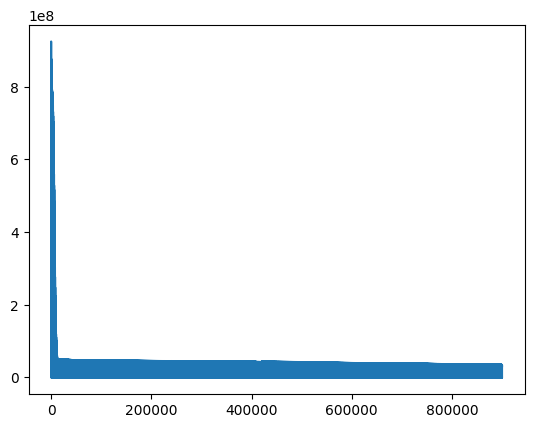

In [991]:
x = [i for i in range(len(losses))]
#print(min(losses))
plt.plot(x, losses)

In [992]:
def predict_car_price(year, mileage, damage_type, number_of_owners, number_of_services, brand):
    # Encode categorical variables
    tokenized_brand = brand_encoder.transform([brand])[0]
    tokenized_damage = damage_encoder.transform([damage_type])[0]
    
    # Create input tensor
    inputs = torch.tensor([
        [year, mileage, tokenized_damage, number_of_owners, number_of_services, tokenized_brand]
    ]).float()
    
    # Make prediction
    prediction = model(inputs)
    
    return prediction.item()


In [993]:
predict_car_price(2021,0,'none',1,0,'Honda')

18607.125

In [994]:
df.sample(10)

,brand,price,year,mileage,damage_type,number_of_owners,number_of_services,tokenized_brand,tokenized_damage
2,Chevrolet,11995,2017,77315,none,3,13,0,2
27,Ford,11900,2016,66800,front,3,8,2,1
16,Honda,18533,2020,42289,none,2,7,3,2
22,Toyota,30490,2022,19184,none,1,5,7,2
3,Nissan,9995,2015,94783,none,1,15,6,2
28,Ford,17888,2020,30482,accident,1,5,2,0
21,Toyota,21534,2022,21291,accident,1,6,7,0
20,Toyota,23999,2023,5768,none,1,4,7,2
26,Ford,8999,2015,102779,none,3,27,2,2
10,Toyota,5995,2002,126408,none,2,13,7,2


Text(0, 0.5, 'Price')

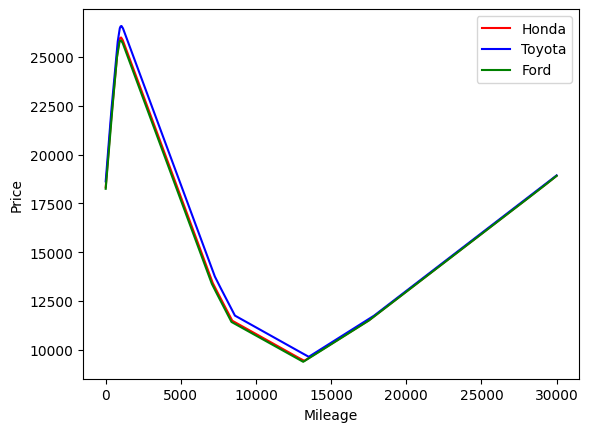

In [995]:
honda_prediction_arr_mileage = []
toyota_prediction_arr_mileage = []
ford_prediction_arr_mileage = []
i=0
while i < 300000:
    honda_prediction_arr_mileage.append(predict_car_price(2024, i, 'none', 1, 5, 'Honda'))
    toyota_prediction_arr_mileage.append(predict_car_price(2024, i, 'none', 1, 5, 'Toyota'))
    ford_prediction_arr_mileage.append(predict_car_price(2024, i, 'none', 1, 5, 'Ford'))
    i += 10
plt.plot([i for i in range(len(honda_prediction_arr_mileage))], honda_prediction_arr_mileage, color='red', label='Honda')
plt.plot([i for i in range(len(toyota_prediction_arr_mileage))], toyota_prediction_arr_mileage, color='blue', label='Toyota')
plt.plot([i for i in range(len(ford_prediction_arr_mileage))], ford_prediction_arr_mileage, color='green', label='Ford')
plt.legend()
plt.xlabel('Mileage')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

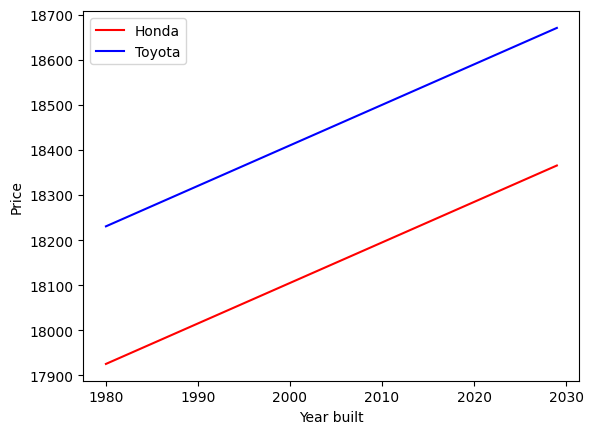

In [996]:
honda_prediction_arr_age = []
toyota_prediction_arr_age = []
ages = []

for i in range(1980, 2030):
    ages.append(i)
    honda_prediction_arr_age.append(predict_car_price(i, 0, 'none', 1, 5, 'Honda'))
    toyota_prediction_arr_age.append(predict_car_price(i, 0, 'none', 1, 5, 'Toyota'))

plt.plot(ages, honda_prediction_arr_age, color='red', label='Honda')
plt.plot(ages, toyota_prediction_arr_age, color='blue', label='Toyota')
plt.legend()
plt.xlabel('Year built')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

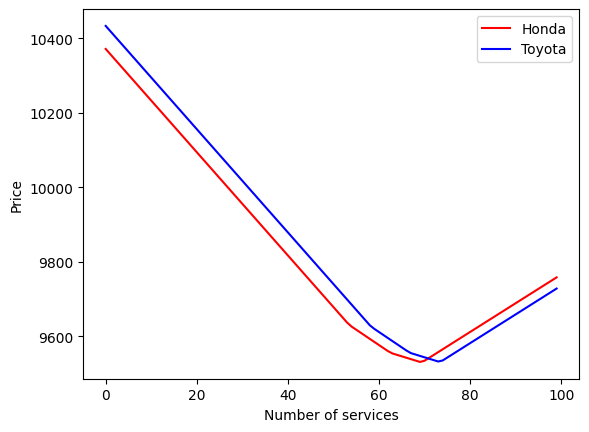

In [997]:
honda_prediction_services_arr = []
toyota_prediction_services_arr = []
i=0
while i < 100:
    honda_prediction_services_arr.append(predict_car_price(2024, 150000, 'none', 1, i, 'Honda'))
    toyota_prediction_services_arr.append(predict_car_price(2024, 150000, 'none', 1, i, 'Toyota'))
    i += 1
plt.plot([i for i in range(len(honda_prediction_services_arr))], honda_prediction_services_arr, color='red', label='Honda')
plt.plot([i for i in range(len(toyota_prediction_services_arr))], toyota_prediction_services_arr, color='blue', label='Toyota')
plt.legend()
plt.xlabel('Number of services')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

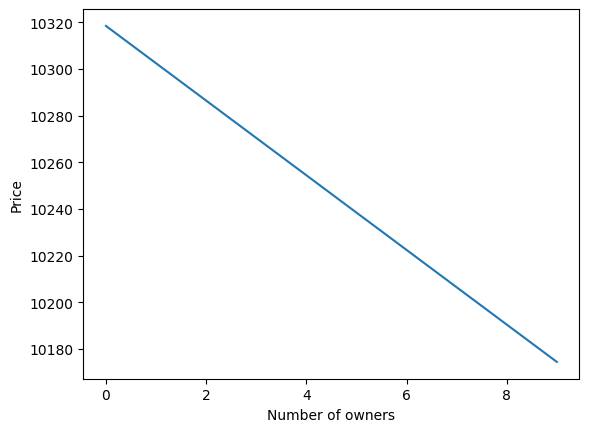

In [998]:
honda_prediction_owner_arr = []
i=0
while i < 10:
    honda_prediction_owner_arr.append(predict_car_price(2024, 150000, 'none', i, 5, 'Honda'))
    i += 1
plt.plot([i for i in range(len(honda_prediction_owner_arr))], honda_prediction_owner_arr, )
plt.xlabel('Number of owners')
plt.ylabel('Price')

In [999]:
predict_car_price(2010, 175000, 'none', 1, 100, 'Honda')

11396.3818359375

</h> I wonder if a decision tree would work better <h>

In [1000]:
import sklearn
from sklearn.tree import DecisionTreeRegressor

In [1001]:
model_decision_tree = DecisionTreeRegressor(criterion='squared_error')
model_decision_tree.fit(df[['year', 'mileage', 'tokenized_damage', 'number_of_owners', 'number_of_services', 'tokenized_brand']], df['price'])

DecisionTreeRegressor()

In [1002]:
def decision_tree_predict(year, mileage, damage_type, number_of_owners, number_of_services, brand):
    tokenized_brand = brand_encoder.transform([brand])[0]
    tokenized_damage = damage_encoder.transform([damage_type])[0]
    return model_decision_tree.predict([[year, mileage, tokenized_damage, number_of_owners, number_of_services, tokenized_brand]])[0]

In [1006]:
def compare_models(year, mileage, damage_type, number_of_owners, number_of_services, brand, price):
    decision_tree_prediction = decision_tree_predict(year, mileage, damage_type, number_of_owners, number_of_services, brand)
    neural_network_prediction = predict_car_price(year, mileage, damage_type, number_of_owners, number_of_services, brand)
    print(f"Decision tree: {decision_tree_prediction}, Neural Network: {neural_network_prediction}")
    print(f"Real price: {price}")
    print(f"\n")
    print(f"Decision tree error: {abs(price - decision_tree_prediction)}")
    print(f"Neural network error: {abs(price - neural_network_prediction)}")
    print(f"\n")

In [1011]:
compare_models(2011, 104992, 'none', 2, 10, 'Ford', 5999)

Decision tree: 5999.0, Neural Network: 9938.4326171875
Real price: 5999


Decision tree error: 0.0
Neural network error: 3939.4326171875




c:\Users\cap10\Desktop\programming\PyTorchModels\CarPredictor\car_venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [1]:
compare_models(2021, 23734, 'none', 1, 5, 'Honda', 25997)

NameError: name 'compare_models' is not defined

In [1013]:
compare_models(2021, 15679, 'none', 1, 6, 'Toyota', 28490)

Decision tree: 30490.0, Neural Network: 25399.37890625
Real price: 28490


Decision tree error: 2000.0
Neural network error: 3090.62109375




c:\Users\cap10\Desktop\programming\PyTorchModels\CarPredictor\car_venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [1014]:
compare_models(2023, 2178, 'none', 1, 5, 'Toyota', 24499)

Decision tree: 30490.0, Neural Network: 20663.64453125
Real price: 24499


Decision tree error: 5991.0
Neural network error: 3835.35546875




c:\Users\cap10\Desktop\programming\PyTorchModels\CarPredictor\car_venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [1015]:
compare_models(2022, 99998, 'none', 1, 11, 'Toyota', 17999)

Decision tree: 11977.0, Neural Network: 10668.04296875
Real price: 17999


Decision tree error: 6022.0
Neural network error: 7330.95703125




c:\Users\cap10\Desktop\programming\PyTorchModels\CarPredictor\car_venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [ ]:
food = {
    fortnite: 'good',
    hotdog: 'good',
    pizza: 'good',
    burger: 'good',
    soup: 'wet',
    salad: 'green',
    icecream: 'cold'
}